In [7]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [8]:
preprocessor = joblib.load("preprocessor.joblib")
X_train, X_test, y_train, y_test = joblib.load("splits.joblib")

ROC AUC: 0.9547847186493401
              precision    recall  f1-score   support

           0      0.916     0.999     0.956      1801
           1      0.988     0.498     0.663       327

    accuracy                          0.922      2128
   macro avg      0.952     0.749     0.809      2128
weighted avg      0.927     0.922     0.911      2128



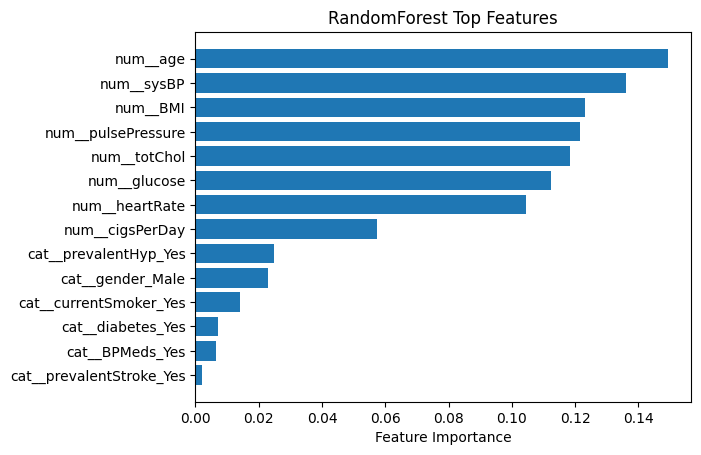

In [9]:
# Pipeline: preprocessor + RandomForest
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,       # number of trees
        max_depth=None,         # let it grow deep (tune later)
        random_state=42,
        class_weight="balanced" # handle imbalance
    ))
])

# Train
rf_clf.fit(X_train, y_train)

# Predict
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

# Feature importance
import matplotlib.pyplot as plt
import numpy as np

importances = rf_clf.named_steps["classifier"].feature_importances_
feat_names = rf_clf.named_steps["preprocessor"].get_feature_names_out()

indices = np.argsort(importances)[::-1][:15]
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [feat_names[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("RandomForest Top Features")
plt.show()

In [10]:
from sklearn.metrics import precision_recall_curve

y_proba = rf_clf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Example: use threshold 0.3
y_pred_thresh = (y_proba >= 0.3).astype(int)
print(classification_report(y_test, y_pred_thresh, digits=3))

              precision    recall  f1-score   support

           0      0.957     0.973     0.965      1801
           1      0.835     0.758     0.795       327

    accuracy                          0.940      2128
   macro avg      0.896     0.866     0.880      2128
weighted avg      0.938     0.940     0.939      2128



In [11]:
joblib.dump(rf_clf, "heart_rf_pipeline.pkl")

['heart_rf_pipeline.pkl']

In [6]:
import joblib
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report

# Load artifacts you already saved
preprocessor = joblib.load("preprocessor.joblib")
X_train, X_test, y_train, y_test = joblib.load("splits.joblib")

# Class weights to handle imbalance (passed as sample weights)
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw_map = {0: cw[0], 1: cw[1]}
sample_weight = np.where(y_train == 1, cw_map[1], cw_map[0])

# Pipeline: preprocessor + MLP
mlp_sklearn = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-4,            # L2 regularization
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42,
        verbose=True           # prints epochs
    ))
])

# Fit (note: pass sample_weight into the clf step)
mlp_sklearn.fit(X_train, y_train, clf__sample_weight=sample_weight)

# Evaluate
y_proba = mlp_sklearn.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print("Sklearn MLP ROC AUC:", auc)

# Choose threshold by maximizing F1
prec, rec, thr = precision_recall_curve(y_test, y_proba)
thr = np.r_[0, thr]
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
best_thr = float(thr[best_idx])
print(f"Best F1 threshold: {best_thr:.2f} (P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f})")

y_pred = (y_proba >= best_thr).astype(int)
print(classification_report(y_test, y_pred, digits=3))

Iteration 1, loss = 0.64362825
Validation score: 0.662067
Iteration 2, loss = 0.61102295
Validation score: 0.649957
Iteration 3, loss = 0.60114414
Validation score: 0.665196
Iteration 4, loss = 0.59555264
Validation score: 0.654448
Iteration 5, loss = 0.58960195
Validation score: 0.655522
Iteration 6, loss = 0.58648464
Validation score: 0.656884
Iteration 7, loss = 0.57984152
Validation score: 0.664550
Iteration 8, loss = 0.57710978
Validation score: 0.654759
Iteration 9, loss = 0.57300171
Validation score: 0.664550
Iteration 10, loss = 0.56782766
Validation score: 0.657530
Iteration 11, loss = 0.56304883
Validation score: 0.667344
Iteration 12, loss = 0.55751331
Validation score: 0.675967
Iteration 13, loss = 0.55356086
Validation score: 0.677399
Iteration 14, loss = 0.54763124
Validation score: 0.687026
Iteration 15, loss = 0.54457871
Validation score: 0.684972
Iteration 16, loss = 0.53898638
Validation score: 0.685594
Iteration 17, loss = 0.53529235
Validation score: 0.687050
Iterat